# Optymalizacja tras dostaw za pomocą algorytmu genetycznego

## 1. Opis projektu
### 1.1 Cel projektu
Celem projektu jest zaimplementowanie algorytmu genetycznego (GA), który optymalizuje trasę kuriera odwiedzającego zestaw punktów (wariant problemu komiwojażera – TSP). Celem algorytmu jest znalezienie najkrótszej możliwej trasy przechodzącą przez wszystkie punkty. W ramach projektu przeprowadzono eksperymenty porównujące różne warianty operatorów GA, a także zestawiono skuteczność GA z algorytmem zachłannym (nearest neighbour) i losowym.

### 1.2 Reprezentacja problemu
- Punkty są rozmieszczone na płaszczyźnie 2D
- Trasa musi wrócić do punktu początkowego (pełny cykl – klasyczny TSP)

### 1.3 Algorytm genetyczny - szczegóły techniczne
- Reprezentacja chromosomu to permutacja miast (lista indeksów)
- Fitness score jest liczone jako odwrotność długości trasy: `1/total_distance`
- Zastosowano Grid Search do znalezienia najlepszego połączenia funkcji selekcji, funkcji mutacji, funkcji krzyżowania oraz prawdopodobieństwa mutacji
- Rozmiar populacji to 5 * liczba miast
- Algorytm kończy pracę jeżeli nie było poprawy od 100 pokoleń lub po przekroczeniu liczby 3000 pokoleń

## 2. Algorytm
### 2.1 Funkcje pomocnicze i importy 

In [1]:
import random
import pandas as pd
from itertools import product
from statistics import mean, stdev
from tqdm import tqdm
import random
from IPython.display import display
from itertools import permutations
import time
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import tsplib95
import numpy as np
import re

def generate_random_instance(num_cities, x_limit=1000, y_limit=1000):
    return np.random.rand(num_cities, 2) * np.array([x_limit, y_limit])

def total_distance(route, points):
    ordered = points[route + [route[0]]]
    diffs = np.diff(ordered, axis=0)
    return np.sum(np.sqrt(np.sum(diffs**2, axis=1)))

def fitness(route, points):
    return 1.0 / total_distance(route, points)

### 2.2 Implementacja algorytmu
#### 2.2.1 Inicjalizacja populacji

In [2]:
def init_population(pop_size, num_cities):
    base = np.tile(np.arange(num_cities), (pop_size, 1))
    [np.random.shuffle(row) for row in base]
    return base.tolist()

#### 2.2.2 Funkcje selekcji
- Selekcja ruletkowa: osobniki są wybierane z prawdopodobieństwem proporcjonalnym do ich przystosowania — im lepszy, tym większa szansa.
- Selekcja turniejowa: losuje się kilku osobników, a wygrywa najlepszy z nich — powtarzane tyle razy, ile potrzeba.
- Selekcja rankingowa: osobniki są sortowane według jakości, a prawdopodobieństwo wyboru zależy od ich miejsca w rankingu, a nie od surowego fitnessu.

In [3]:
def selection_roulette(population, fitness_scores, num_selections):
    total_fit = sum(fitness_scores)
    pick = np.random.uniform(0, total_fit, num_selections)
    selected = []
    cumfit = np.cumsum(fitness_scores)
    for p in pick:
        idx = np.searchsorted(cumfit, p)
        selected.append(population[idx])
    return selected

def selection_tournament(population, fitness_scores, num_selections):
    selected = []
    pop_fit = list(zip(population, fitness_scores))
    for _ in range(num_selections):
        best = max(random.sample(pop_fit, 3), key=lambda x: x[1])[0]
        selected.append(best)
    return selected

def selection_ranking(population, fitness_scores, num_selections):
    sorted_pop = [p for p, _ in sorted(zip(population, fitness_scores), key=lambda x: x[1])]
    ranks = np.arange(1, len(population)+1)
    probs = ranks / ranks.sum()
    indices = np.random.choice(len(population), num_selections, p=probs)
    return [sorted_pop[i] for i in indices]

#### 2.2.3 Funkcje mutacji
- Inversion - odwrócenie kolejności punktów w losowym fragmencie trasy
- Swap - zamiana miejscami dwóch losowo wybranych punktów w trasie

In [4]:
def mutation_swap(individual, mutation_rate):
    if random.random() < mutation_rate:
        i, j = np.random.choice(len(individual), 2, replace=False)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

def mutation_inversion(individual, mutation_rate):
    if random.random() < mutation_rate:
        i, j = sorted(np.random.choice(len(individual), 2, replace=False))
        individual[i:j+1] = individual[i:j+1][::-1]
    return individual

#### 2.2.4 Krzyżowania
- Order Crossover (OX): zachowuje kolejność i względną pozycję miast z jednego rodzica, uzupełniając resztę bez duplikatów zgodnie z kolejnością drugiego.
- Partially Mapped Crossover (PMX): wymienia fragmenty rodziców i tworzy mapowanie pozycji, aby zachować spójność i uniknąć powtórzeń, przepisując konflikty zgodnie z tą mapą.

In [5]:
def order_crossover(p1, p2):
    size = len(p1)
    a, b = sorted(np.random.choice(size, 2, replace=False))
    hole = set(p1[a:b+1])
    child = [None]*size
    child[a:b+1] = p1[a:b+1]
    fill = [x for x in p2 if x not in hole]
    i = 0
    for idx in list(range(0, a)) + list(range(b+1, size)):
        child[idx] = fill[i]
        i += 1
    return child

def pmx_crossover(p1, p2):
    size = len(p1)
    a, b = sorted(np.random.choice(size, 2, replace=False))
    child = [None]*size
    child[a:b+1] = p1[a:b+1]
    for i in range(a, b+1):
        if p2[i] not in child:
            val = p2[i]
            pos = i
            while True:
                mapped_val = p1[pos]
                pos = p2.index(mapped_val)
                if child[pos] is None:
                    break
            child[pos] = val
    for i in range(size):
        if child[i] is None:
            child[i] = p2[i]
    return child

#### 2.2.5 Tworzenie następnego pokolenia

In [6]:
def new_generation(population, points, selection_func, mutation_func, mutation_rate, crossover_func, fitnesses=None):
    if fitnesses is None:
        fitnesses = [fitness(ind, points) for ind in population]
    pop_size = len(population)
    selected = selection_func(population, fitnesses, 2 * pop_size)
    children = []
    for i in range(0, len(selected), 2):
        child = crossover_func(selected[i], selected[i+1])
        child = mutation_func(child, mutation_rate)
        children.append(child)
    return children[:pop_size]

#### 2.2.6 Pętla główna

In [7]:
def run_ga(points, generations_limit, selection_func, mutation_func, mutation_rate, crossover_func):
    num_cities = len(points)
    pop_size = 5 * num_cities
    population = init_population(pop_size, num_cities)
    fitnesses = None
    best = None
    best_fit = -np.inf
    no_improve = 0
    fitness_history = []

    for _ in range(generations_limit):
        population = new_generation(population, points, selection_func, mutation_func, mutation_rate, crossover_func, fitnesses)
        fitnesses = [fitness(ind, points) for ind in population]
        max_f = max(fitnesses)
        if max_f > best_fit:
            best_fit = max_f
            best = population[fitnesses.index(max_f)]
            no_improve = 0
        else:
            no_improve += 1
        fitness_history.append(best_fit)
        if no_improve >= 100:
            break

    return best, 1.0 / best_fit, fitness_history

### 2.3 Implementacja benchmarków
- Nearest Neighbour: Buduje trasę zachłannie, zawsze dokładając najbliższe nieodwiedzone miasto.
- Random Search: Generuje losową permutację miast jako trasę bez żadnej optymalizacji.
- Brute Force: Przeszukuje wszystkie możliwe permutacje tras, aby znaleźć absolutnie najkrótszą.
- 2-opt: Lokalnie ulepsza trasę, sukcesywnie odwracając fragmenty trasy, gdy tylko skraca to łączny dystans - można łączyć z innymi algorytmami.

In [8]:
# Zachłanny
def nearest_neighbour(points):
    def distance(a, b):
        return np.linalg.norm(np.array(a) - np.array(b))
    unvisited = set(range(len(points)))
    path = [0]
    unvisited.remove(0)

    while unvisited:
        last = path[-1]
        next_city = min(unvisited, key=lambda city: distance(points[last], points[city]))
        path.append(next_city)
        unvisited.remove(next_city)

    return path

# Random
def random_search(points):
    n = len(points)
    path = list(range(n))
    random.shuffle(path)
    return path

# Brute Force
def brute_force_tsp(points):
    n = len(points)
    best_path = None
    best_distance = float('inf')

    for perm in permutations(range(1, n)):
        path = [0] + list(perm)
        dist = total_distance(path, points)

        if dist < best_distance:
            best_distance = dist
            best_path = path

    return best_path

# 2-approksymacja
def two_opt(route, points):
    best = route
    improved = True

    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if total_distance(new_route, points) < total_distance(best, points):
                    best = new_route
                    improved = True
        route = best
    return best

### 2.4 Grid search - szukanie najlepszego wariantu
W ramach strojenia hiperparametrów algorytmu genetycznego przeprowadzono grid search obejmujący następujące parametry:
- funkcję selekcji: turniejowa, ruletkowa, rankingowa,
- typ mutacji: swap, inversion,
- mutation rate: 0.01, 0.05, 0.1,
- funkcję krzyżowania: order crossover (OX) oraz PMX crossover.

Aby ocenić skuteczność każdej kombinacji, wygenerowano 10 losowych instancji problemu TSP, o liczbie miast losowo dobranej z przedziału od 5 do 100. Każda konfiguracja była testowana na tych samych instancjach, a za kryterium oceny przyjęto średnią długość znalezionego rozwiązania.

#### 2.4.1 Implementacja grid search

In [9]:
def full_grid_search(generations_limit=3000, n_instances=10):
    selection_funcs = [selection_roulette, selection_tournament, selection_ranking]
    mutation_funcs = [mutation_swap, mutation_inversion]
    crossover_funcs = [order_crossover, pmx_crossover]
    mutation_rates = [0.01, 0.05, 0.1]
    results = []

    config_space = list(product(selection_funcs, mutation_funcs, mutation_rates, crossover_funcs))

    for instance_idx in tqdm(range(n_instances), desc="Instances"):
        points = generate_random_instance(random.randint(5, 100))
        for sel, mut, rate, cross in config_space:
            _, dist, _ = run_ga(points, generations_limit, sel, mut, rate, cross)
            results.append({
                "instance_id": instance_idx,
                "selection": sel.__name__,
                "mutation": mut.__name__,
                "mutation_rate": rate,
                "crossover": cross.__name__,
                "distance": dist,
            })

    df = pd.DataFrame(results)
    summary_df = df.groupby(["selection", "mutation", "mutation_rate", "crossover"]).agg(
        avg_distance=("distance", "mean"),
        std_distance=("distance", "std")
    ).sort_values("avg_distance").reset_index()

    display(summary_df)

#### 2.4.2 Odpalenie grid search - wyniki

In [25]:
full_grid_search()

Instances: 100%|██████████| 10/10 [28:16<00:00, 169.66s/it] 


,selection,mutation,mutation_rate,crossover,avg_distance,std_distance
0,selection_tournament,mutation_inversion,0.10,pmx_crossover,5650.984547,1772.242839
1,selection_tournament,mutation_inversion,0.05,pmx_crossover,5660.647708,1714.610074
2,selection_tournament,mutation_inversion,0.05,order_crossover,5757.910985,1768.530917
3,selection_ranking,mutation_inversion,0.05,pmx_crossover,5818.777172,1771.899413
4,selection_tournament,mutation_inversion,0.01,order_crossover,6027.360107,1997.184490
5,selection_tournament,mutation_swap,0.10,order_crossover,6249.795381,2229.702751
6,selection_tournament,mutation_inversion,0.01,pmx_crossover,6466.264183,2267.627438
7,selection_tournament,mutation_inversion,0.10,order_crossover,6594.648752,3836.815833
8,selection_tournament,mutation_swap,0.05,order_crossover,6594.905741,2601.303298
9,selection_ranking,mutation_swap,0.10,pmx_crossover,6845.853262,2705.464967


Najlepszym wariantem jest algorytm genetyczny gdzie funkcją selekcji jest selekcja turniejowa, mutacja jest typu inversion, mutation rate to 10%, a wariant krzyżowania to pmx_crossover.


## 3. Testowanie

### 3.1 Wstęp
Przeprowadzono dwa typy testów z zamiarem oceny skuteczności GA oraz porównania go do innych algorytmów do rozwiązywania TSP:

- Testy na losowych instancjach – Dla rozmiarów problemu n ∈ {5, 10, 20, 50, 100} wygenerowano po 10 losowych instancji. W tych testach nie jest znana optymalna długości trasy, więc porównywane są tylko czas działania i długość znalezionej trasy pomiędzy algorytmami.

- Testy na instancjach z TSPLIB – Przeprowadzono testy na czterech instancjach z TSPLIB: n ∈ {11, 29, 52, 100, 442}. W tym przypadku biblioteka udostępnia prawidłowe rozwiązanie, zatem można porównać odległość rozwiązania od optimum.

GA porównano z algorytmami Brute Force (dla n do maksymalnie 10), zachłannym (Nearest Neighbour), losowym, oraz 2-OPT.

### 3.2 Odpalenie testów

#### 3.2.1 Testy na losowych instancjach

In [32]:
results = []
ns = [5, 10, 20, 50, 100] # Rozmiary problemów

for n in ns:
    for instance_idx in range(10):
        points = generate_random_instance(n)

        for name, solver in [
            ("Genetic", lambda pts: run_ga(pts, 3000, selection_tournament, mutation_inversion, 0.1, pmx_crossover)[0]),
            ("NearestNeighbour", nearest_neighbour),
            ("Random", random_search),
            ("BruteForce", brute_force_tsp if n <= 10 else None),
        ]:
            
            if solver is None:
                continue

            start = time.time()
            route = solver(points)
            end = time.time()

            dist = total_distance(route, points)

            results.append({
                "n": n,
                "instance_idx": instance_idx,
                "algorithm": name,
                "distance": dist,
                "time": end - start,
                "route": route,
                "points": points
            })

            if name != "BruteForce":
                # Optymalizacja 2-Opt
                start_2opt = time.time()
                improved_route = two_opt(route, points)
                end_2opt = time.time()

                results.append({
                    "n": n,
                    "instance_idx": instance_idx,
                    "algorithm": name + " + 2-Opt",
                    "distance": total_distance(improved_route, points),
                    "time": (end - start) + (end_2opt - start_2opt),  # czas działania algorytmu + czas optymalizacji
                    "route": improved_route,
                    "points": points
                })

df = pd.DataFrame(results)
df.to_csv("test_results.csv", index=False)

#### 3.2.2 Testy na instancjach z TSPLIB

In [13]:
def load_tsplib_instance(path):
    problem = tsplib95.load(path)
    node_list = list(problem.get_nodes())
    coords = [problem.node_coords[n] if problem.node_coords else problem.display_data[n] for n in node_list]
    return np.array(coords), node_list

def load_optimal_tour(path):
    with open(path, "r") as f:
        lines = f.readlines()
    tour = []
    reading = False
    for line in lines:
        line = line.strip()
        if line == "TOUR_SECTION":
            reading = True
            continue
        if reading and line not in {"-1", "EOF"}:
            tour.append(int(line) - 1)
    return tour

def evaluate_solver(name, solver_fn, coords, with_fitness=False):
    if with_fitness:
        start = time.time()
        route, best, fitness_history = solver_fn(coords)
        end = time.time()
    else:
        start = time.time()
        route = solver_fn(coords)
        end = time.time()
        fitness_history = None
    
    base_result = {
        "algorithm": name,
        "distance": total_distance(route, coords),
        "time": end - start,
        "route": route,
        "points": coords.tolist(),
        "fitness_history": fitness_history
    }

    # 2-Opt improvement
    start_2opt = time.time()
    improved = two_opt(route, coords)
    end_2opt = time.time()
    result_with_2opt = {
        "algorithm": name + " + 2-Opt",
        "distance": total_distance(improved, coords),
        "time": (end - start) + (end_2opt - start_2opt),
        "route": improved,
        "points": coords.tolist()
    }
    return [base_result, result_with_2opt]

def run_instance(instance):
    results = []
    name = instance["name"]

    if name == "Random11":
        coords = generate_random_instance(11)
        tour = brute_force_tsp(coords)
    else:
        coords, _ = load_tsplib_instance(f"tsplib_data/{instance['tsp_path']}")
        tour = load_optimal_tour(f"tsplib_data/{instance['opt_path']}")

    opt_dist = total_distance(tour, coords)
    results.append({
        "instance": name,
        "n": len(coords),
        "algorithm": "Optimal",
        "distance": opt_dist,
        "time": "-",
        "route": tour,
        "points": coords.tolist()
    })

    solvers = {
        "Genetic": (lambda pts: run_ga(pts, 3000, selection_tournament, mutation_inversion, 0.1, pmx_crossover), True),
        "NearestNeighbour": (nearest_neighbour, False),
        "Random": (random_search, False),
    }

    for alg_name, (solver_fn, has_fitness) in solvers.items():
        for res in evaluate_solver(alg_name, solver_fn, coords, with_fitness=has_fitness):
            res.update({
                "instance": name,
                "n": len(coords)
            })
            results.append(res)

    return results

instances = [
    {"name": "Random11"},
    {"name": "bayg29", "tsp_path": "bayg29.tsp", "opt_path": "bayg29.opt.tour"},
    {"name": "berlin52", "tsp_path": "berlin52.tsp", "opt_path": "berlin52.opt.tour"},
    {"name": "kroA100", "tsp_path": "kroA100.tsp", "opt_path": "kroA100.opt.tour"},
    {"name": "pcb442", "tsp_path": "pcb442.tsp", "opt_path": "pcb442.opt.tour"},
]

all_results = []
for inst in instances:
    all_results.extend(run_instance(inst))

df = pd.DataFrame(all_results)
df.to_csv("tsplib_test_results.csv", index=False)

### 3.3 Wyniki testów

In [ ]:
df_random = pd.read_csv("test_results.csv")

def fix_numpy_string(s):
    # Zamienia spacje między liczbami na przecinki
    s_fixed = re.sub(r'(?<=\d)\s+(?=\d)', ',', s)
    return s_fixed

df_random["time"] = df_random["time"].astype(float)
df_random["route"] = df_random["route"].apply(ast.literal_eval)
df_random["points"] = df_random["points"].apply(fix_numpy_string)

df_tsplib = pd.read_csv("tsplib_test_results.csv")
df_tsplib["time"] = pd.to_numeric(df_tsplib["time"], errors="coerce")
df_tsplib["points"] = df_tsplib["points"].apply(ast.literal_eval)

summary_random = (
    df_random.groupby(["n", "algorithm"])
    .agg(
        mean_distance=("distance", "mean"),
        std_distance=("distance", "std"),
        mean_time=("time", "mean"),
        std_time=("time", "std"),
        min_distance=("distance", "min"),
        max_distance=("distance", "max")
    )
    .sort_values("mean_distance")
    .reset_index()
)

summary_tsplib = (
    df_tsplib
    .groupby(["n", "algorithm"])
    .agg(
        distance=("distance", "mean"),
        time=("time", "mean")
    )
    .sort_values("distance")
    .reset_index()
)
display(summary_random)
display(summary_tsplib)

,n,algorithm,mean_distance,std_distance,mean_time,std_time,min_distance,max_distance
0,5,BruteForce,2413.543697,360.273700,0.000400,0.000516,2024.548776,3140.314420
1,5,Genetic,2413.543697,360.273700,0.105123,0.011450,2024.548776,3140.314420
2,5,Genetic + 2-Opt,2413.543697,360.273700,0.105223,0.011340,2024.548776,3140.314420
3,5,NearestNeighbour + 2-Opt,2463.977150,361.940132,0.000400,0.000517,2024.548776,3140.314420
4,5,Random + 2-Opt,2523.078957,479.349883,0.000300,0.000483,2118.946119,3519.419284
5,5,NearestNeighbour,2532.313696,395.812135,0.000200,0.000422,2118.946119,3170.629599
6,10,BruteForce,2821.083209,396.123722,5.940513,0.044997,2192.024299,3433.096501
7,10,Genetic,2834.886437,381.142324,0.248543,0.056503,2227.296046,3433.096501
8,10,Genetic + 2-Opt,2834.886437,381.142324,0.249343,0.056418,2227.296046,3433.096501
9,10,NearestNeighbour + 2-Opt,2916.808630,477.241344,0.001912,0.000752,2192.024299,3768.233861


,n,algorithm,distance,time
0,11,Optimal,3357.826066,NaN
1,11,Random + 2-Opt,3423.654380,0.004010
2,11,Genetic,3423.654380,0.239671
3,11,Genetic + 2-Opt,3423.654380,0.241128
4,11,NearestNeighbour + 2-Opt,3471.947864,0.003014
5,11,NearestNeighbour,3797.585104,0.001010
6,11,Random,6056.860635,0.000000
7,52,Optimal,7544.365902,NaN
8,52,Genetic + 2-Opt,8148.709388,8.161514
9,52,Genetic,8148.709388,8.112015


### 3.4 Wizualizacja wyników testów

#### 3.4.1 Bezwględna długość trasy

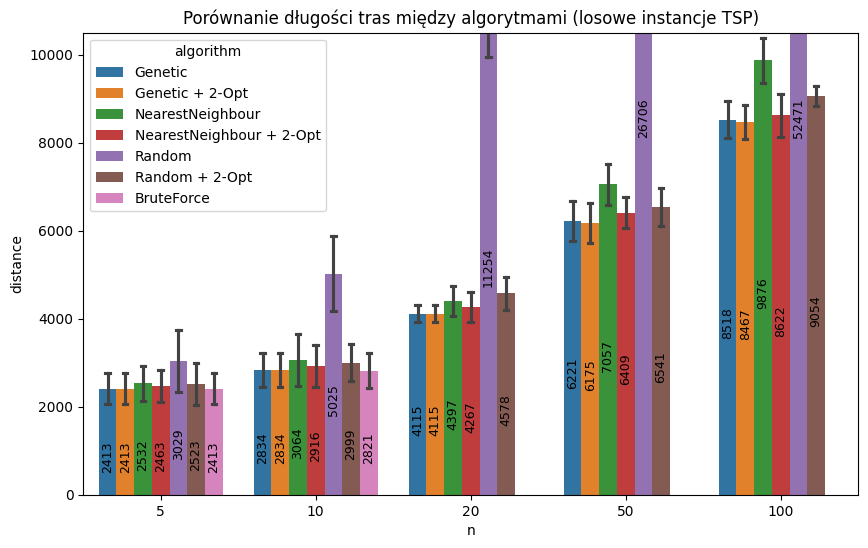

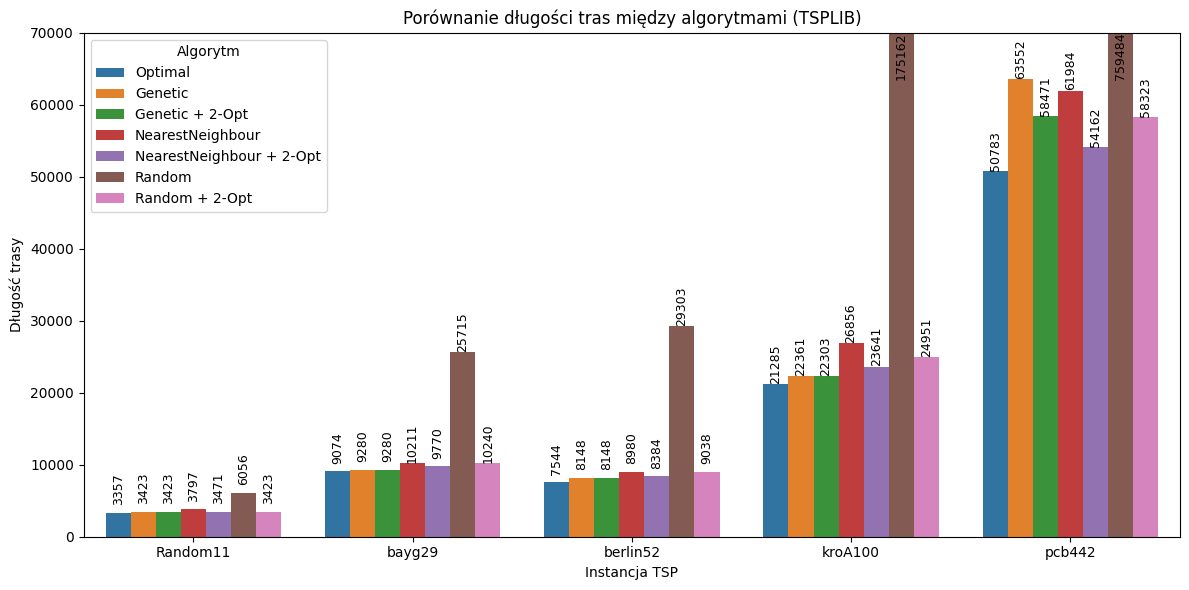

In [103]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_random,
    x="n",
    y="distance",
    hue="algorithm",
    errorbar="sd",
    capsize=0.2
)
plt.ylim(0, 10500)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            min(height / 2, 9000),
            f"{int(height)}",
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            rotation=90
        )
plt.title("Porównanie długości tras między algorytmami (losowe instancje TSP)")

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_tsplib, x="instance", y="distance", hue="algorithm")
plt.ylim(0, 70000)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            min(height + 5500, 70000),
            f"{int(height)}",
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            rotation=90
        )
plt.title("Porównanie długości tras między algorytmami (TSPLIB)")
plt.ylabel("Długość trasy")
plt.xlabel("Instancja TSP")
plt.legend(title="Algorytm")
plt.tight_layout()
plt.show()

#### 3.4.2 Czas działania

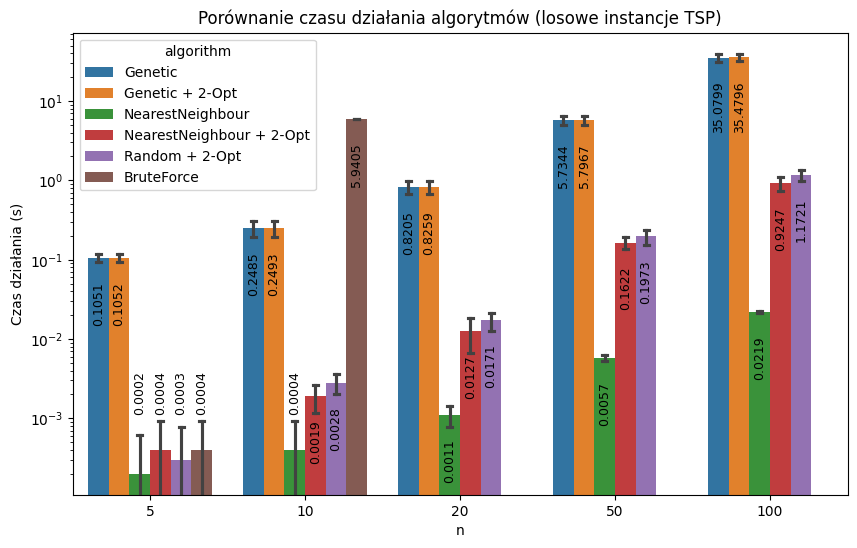

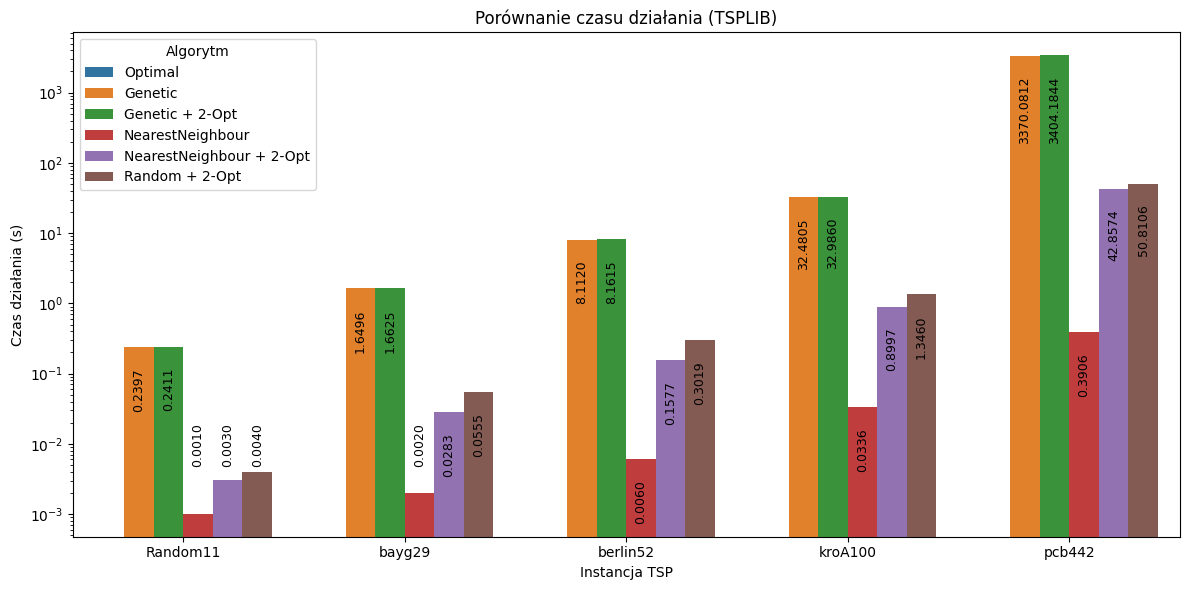

In [104]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_random[df_random["algorithm"] != "Random"],
    x="n",
    y="time",
    hue="algorithm",
    errorbar="sd",
    capsize=0.2
)
plt.yscale("log")
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height / 2 if height > 0.0005 else 0.004,
            f"{height:.4f}",
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            rotation=90
        )
plt.ylabel("Czas działania (s)")
plt.title("Porównanie czasu działania algorytmów (losowe instancje TSP)")

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_tsplib[df_tsplib["algorithm"] != "Random"], x="instance", y="time", hue="algorithm")
plt.yscale("log")
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height / 2 if height > 0.005 else 0.02,
            f"{height:.4f}",
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            rotation=90
        )
plt.title("Porównanie czasu działania (TSPLIB)")
plt.ylabel("Czas działania (s)")
plt.xlabel("Instancja TSP")
plt.legend(title="Algorytm")
plt.tight_layout()
plt.show()

#### 3.4.3 Odchylenie od optimum

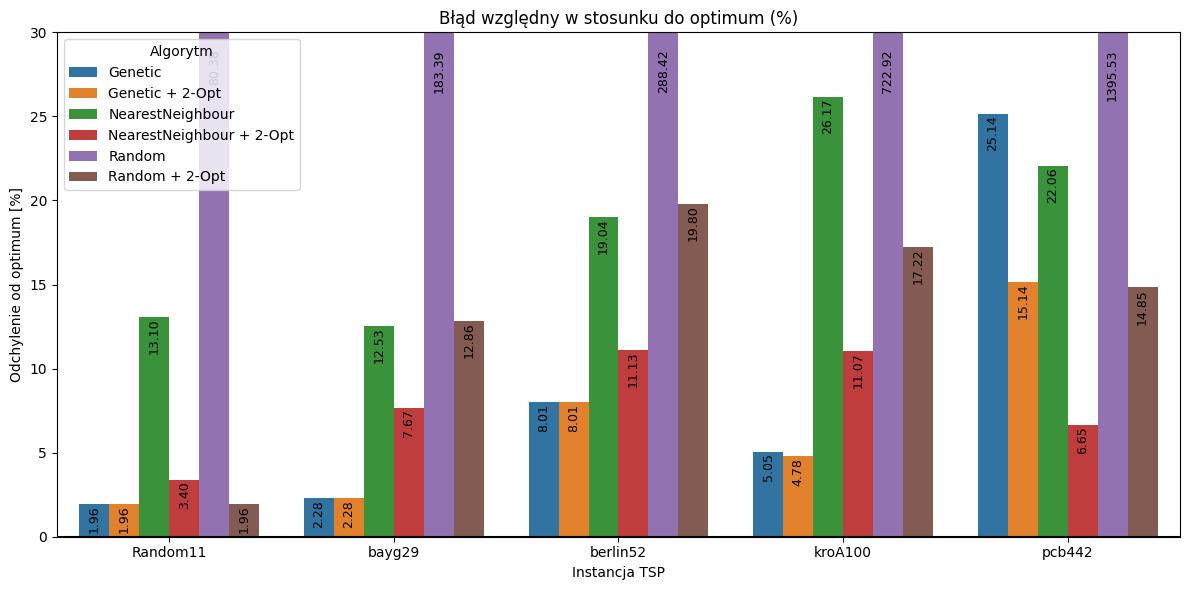

In [111]:
df_opt = df_tsplib[df_tsplib["algorithm"] == "Optimal"][["instance", "distance"]].rename(columns={"distance": "optimal_distance"})
df_merged = df.merge(df_opt, on="instance")
df_merged["error_pct"] = 100 * (df_merged["distance"] - df_merged["optimal_distance"]) / df_merged["optimal_distance"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_merged[df_merged["algorithm"] != "Optimal"], x="instance", y="error_pct", hue="algorithm")
plt.axhline(0, color="black")
plt.title("Błąd względny w stosunku do optimum (%)")
plt.ylabel("Odchylenie od optimum [%]")
plt.ylim(0, 30)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            min(height - 0.1, 29),
            f"{height:.2f}",
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            rotation=90
        )
plt.xlabel("Instancja TSP")
plt.legend(title="Algorytm")
plt.tight_layout()
plt.show()

#### 3.4.4 Porównania znalezionych tras

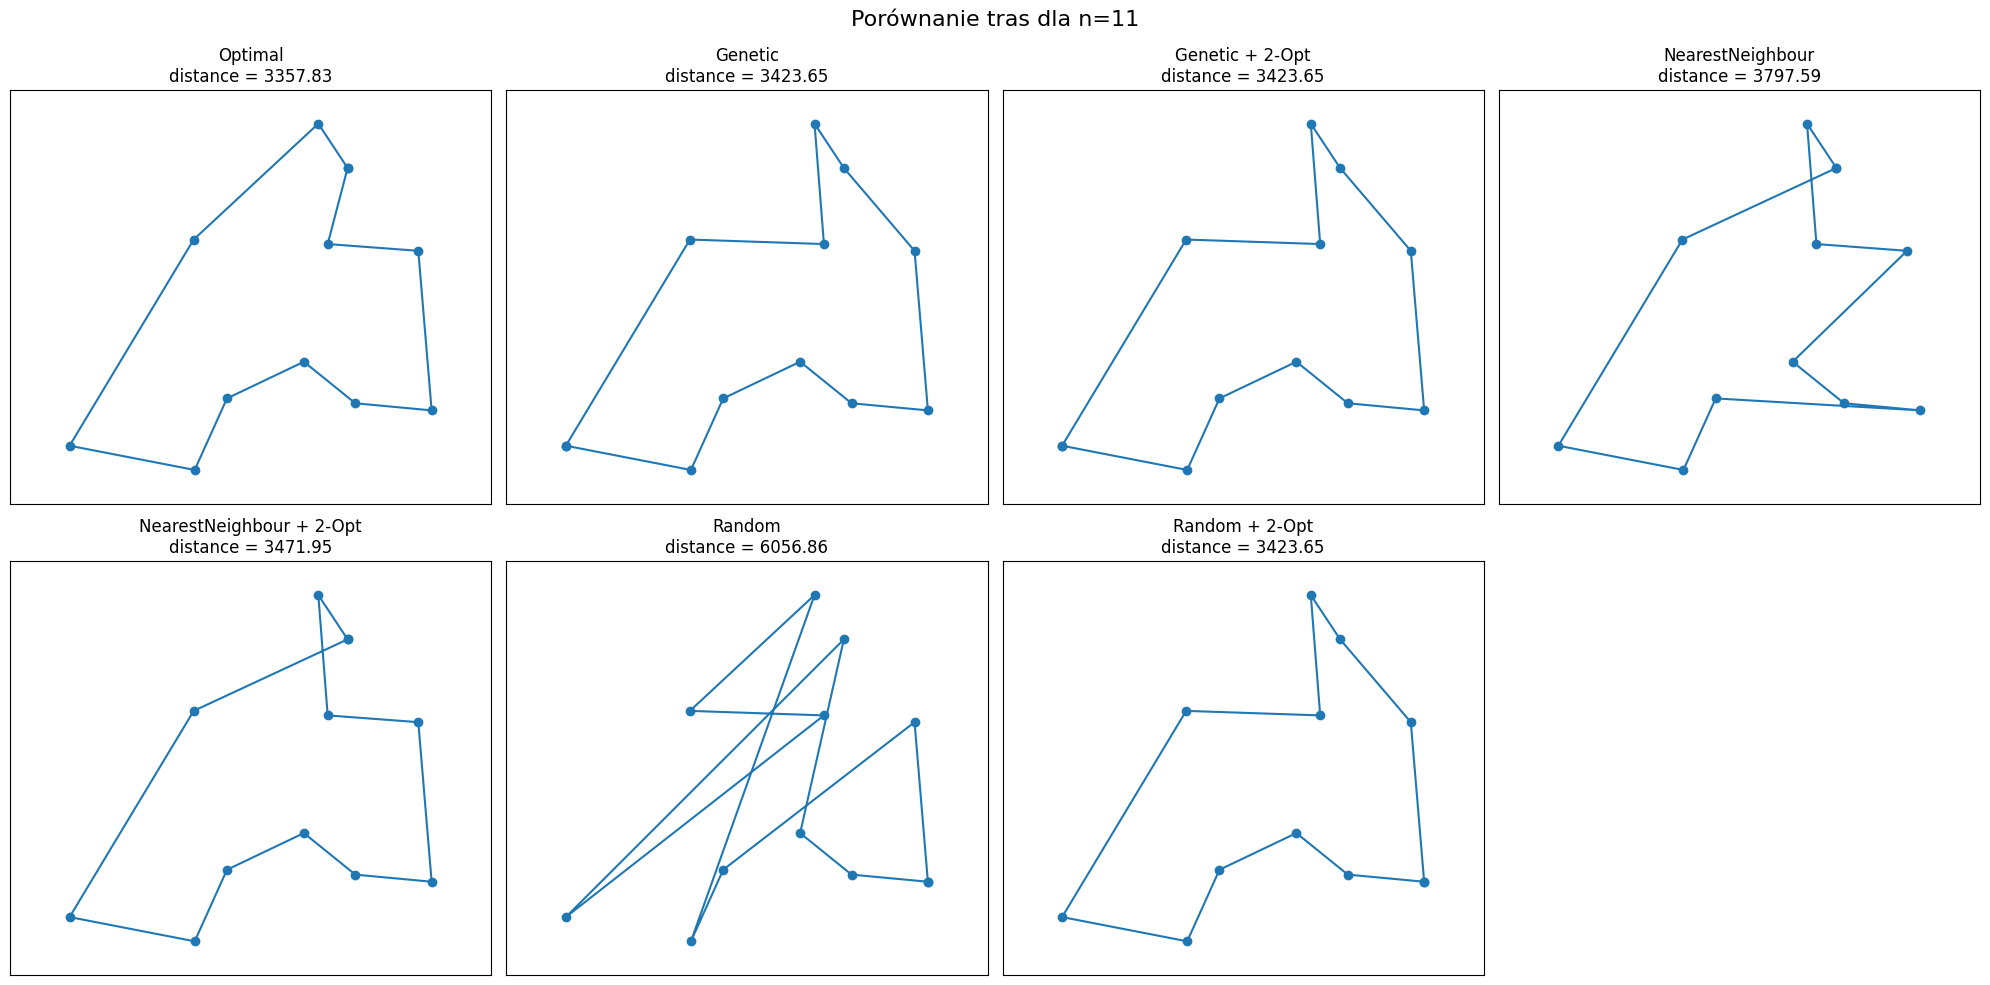

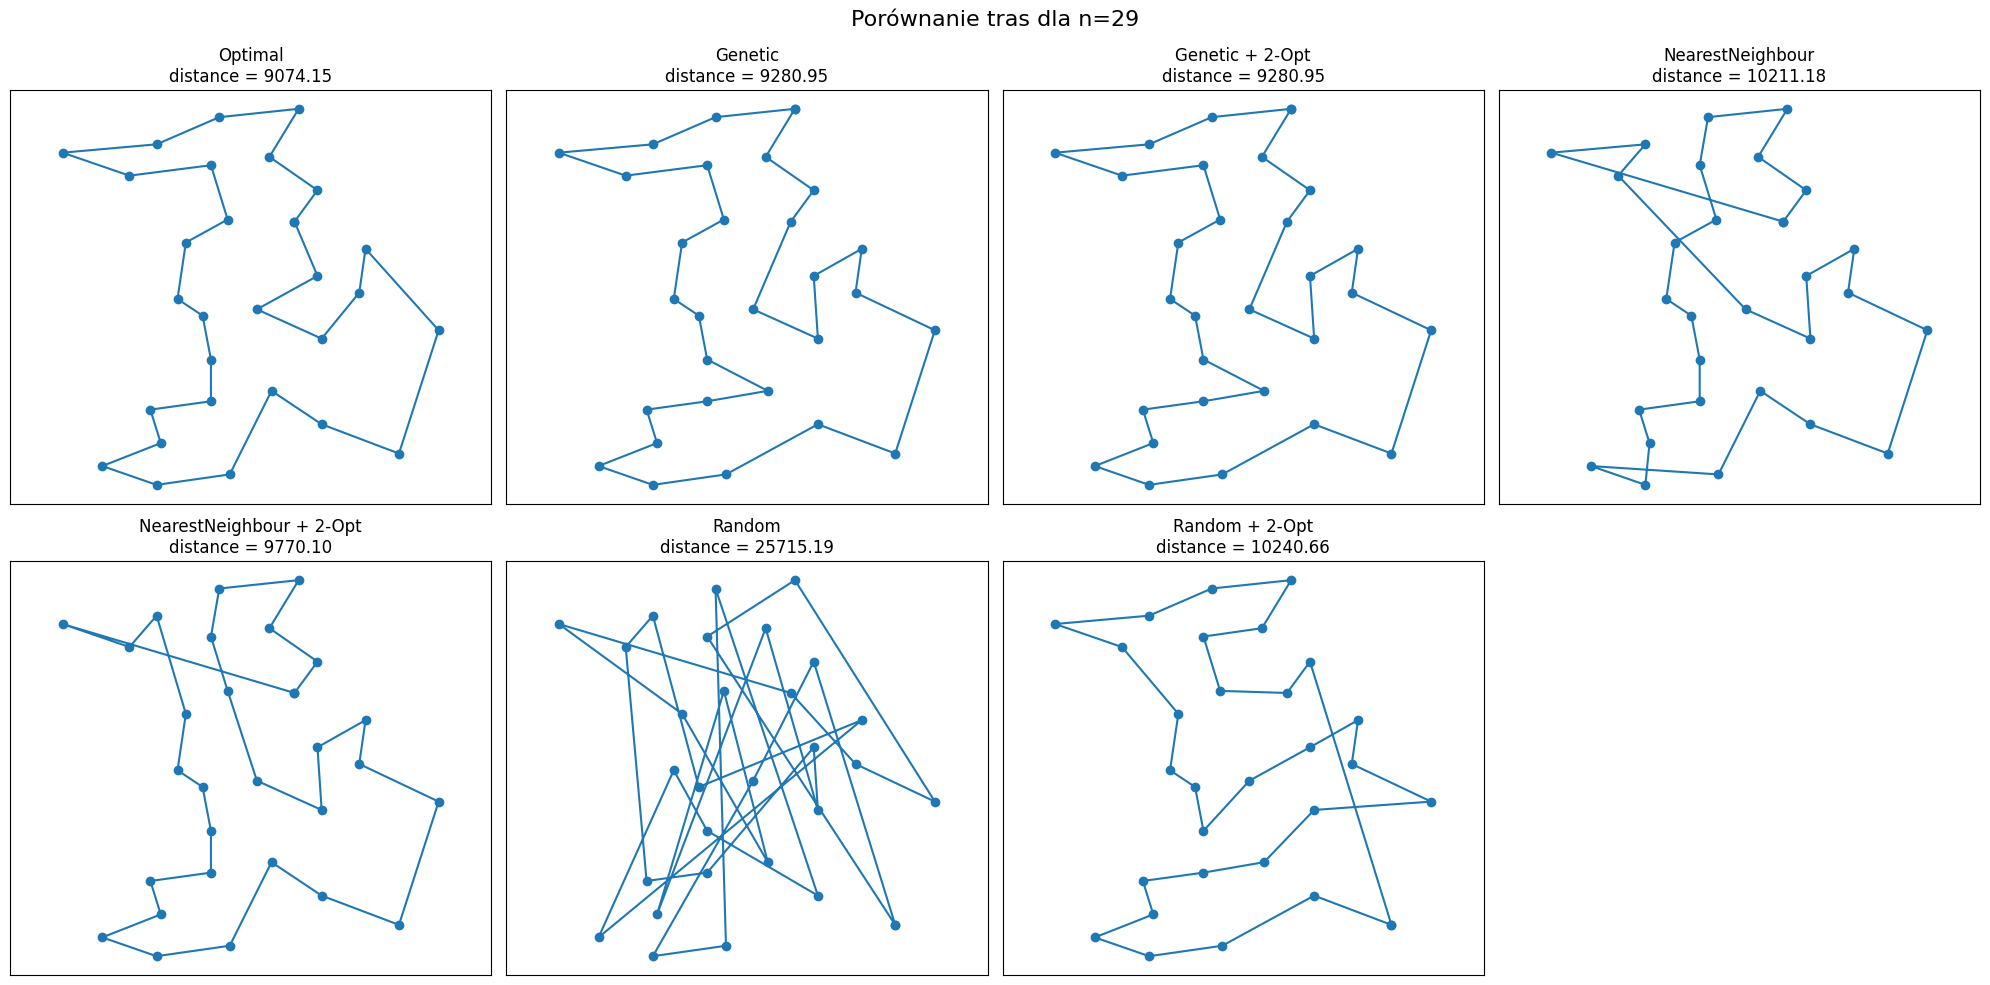

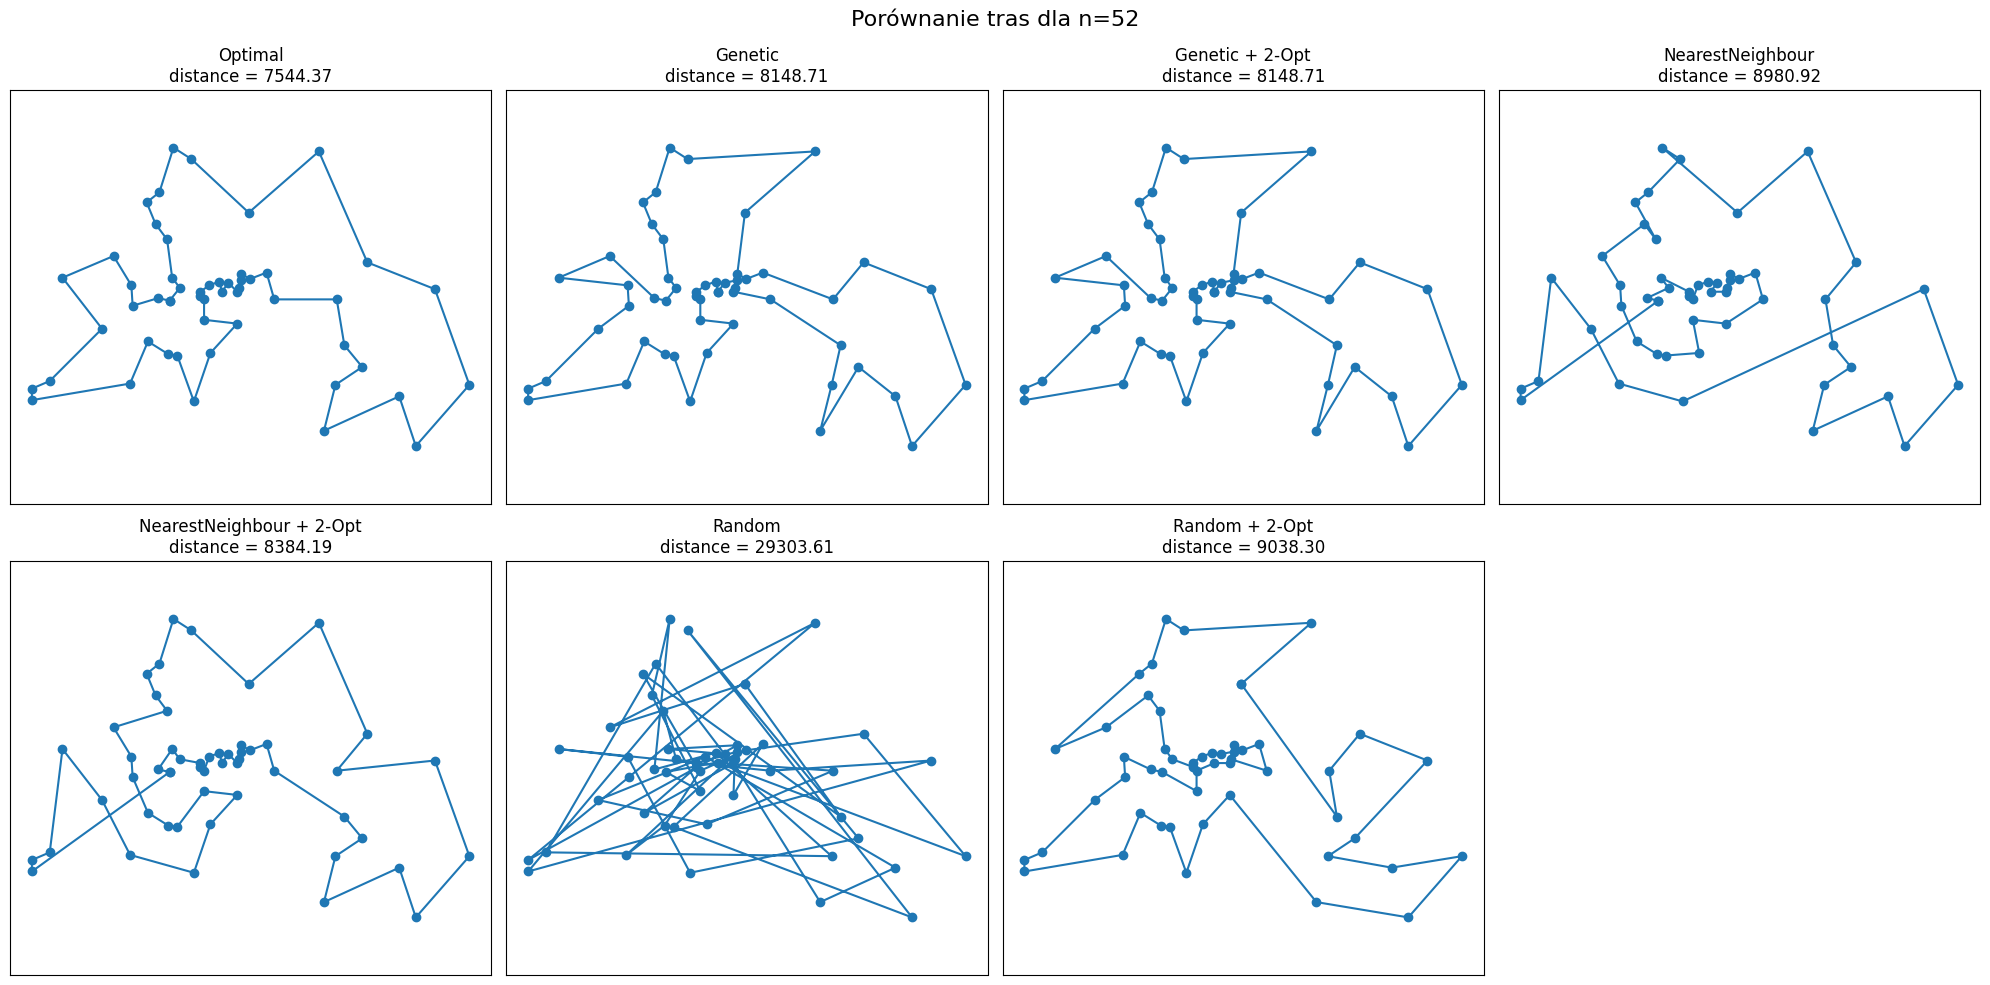

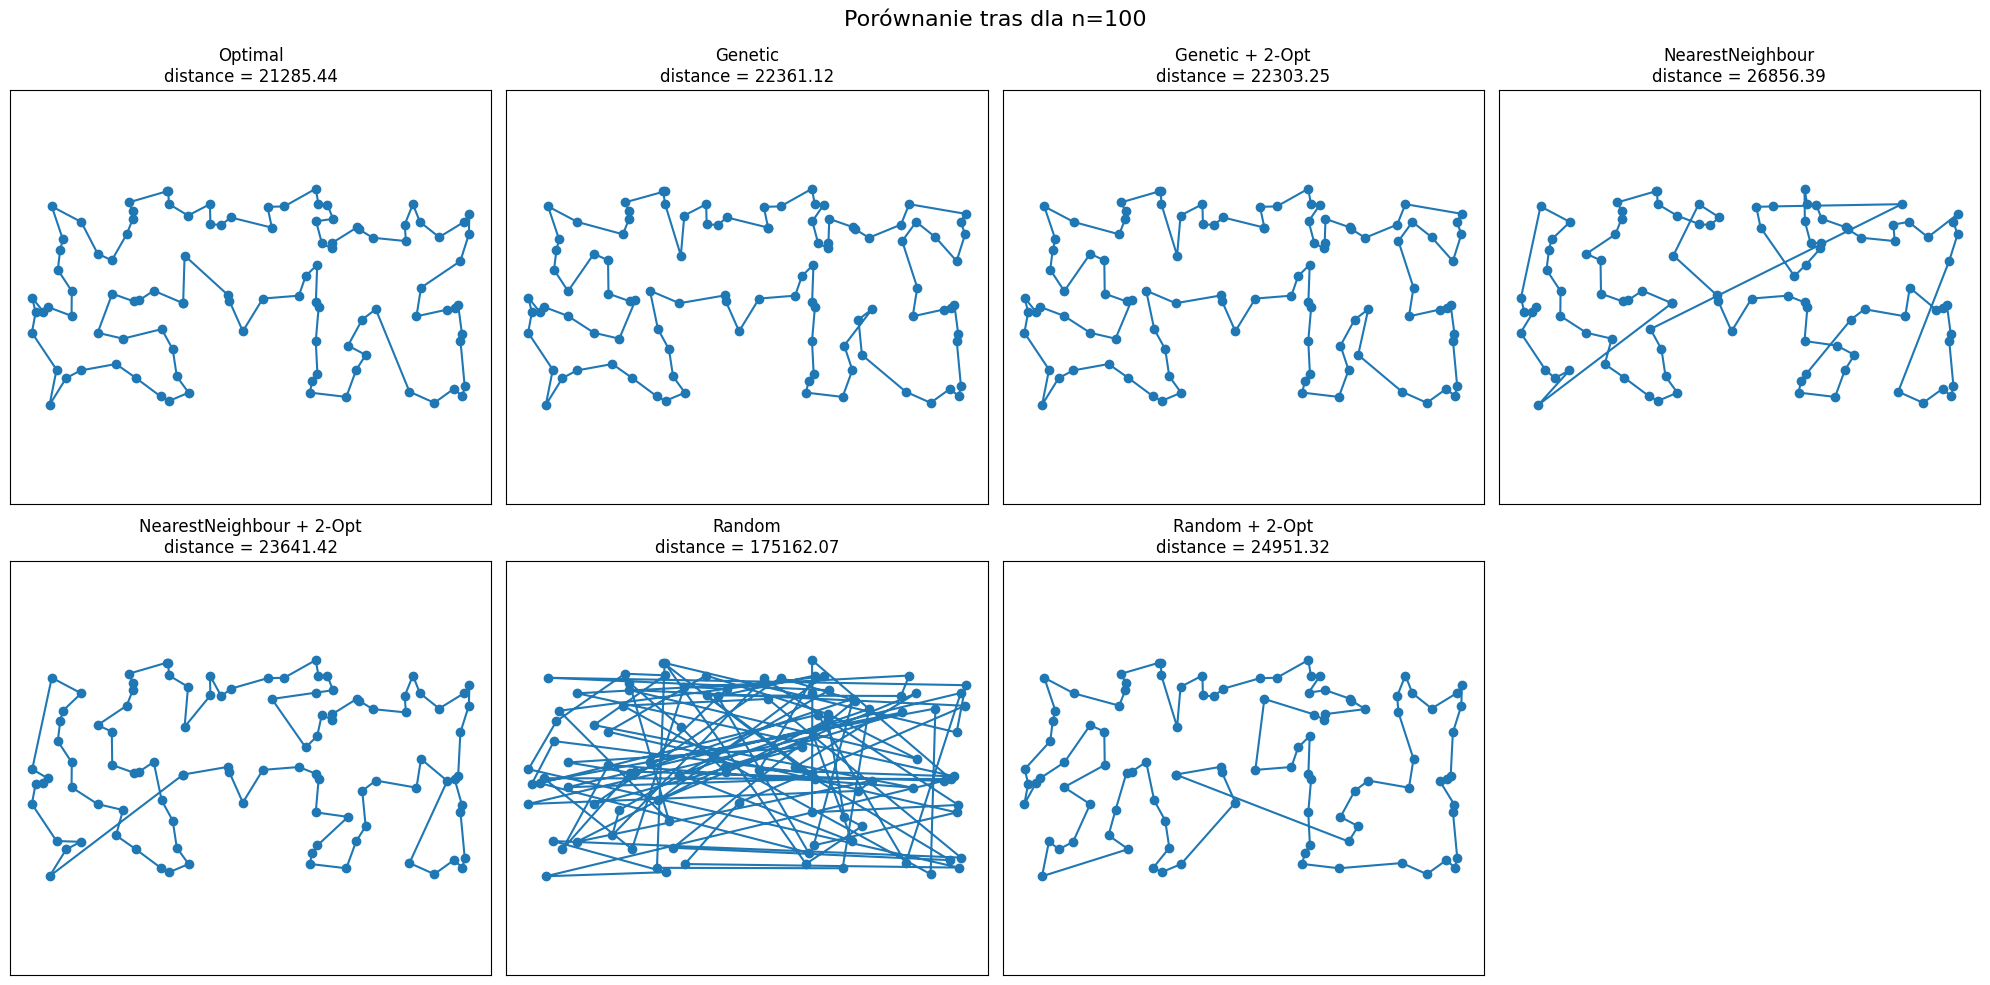

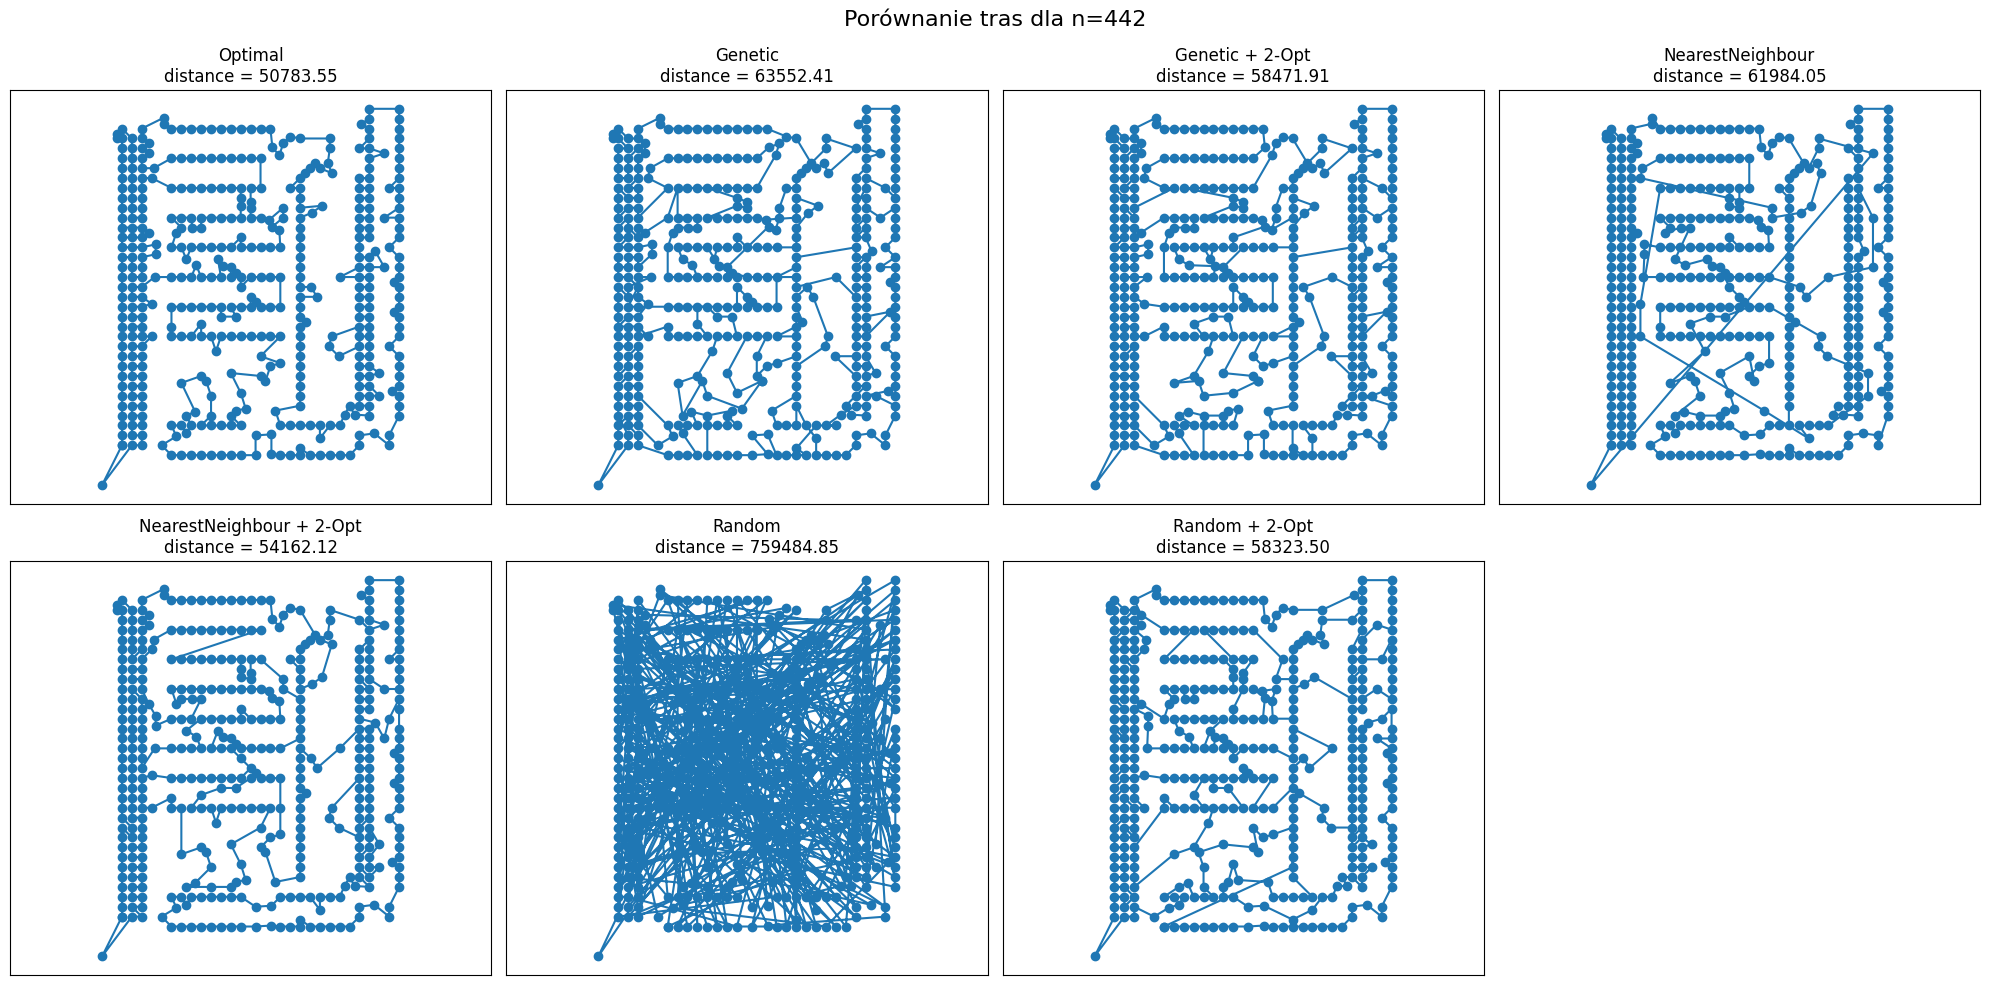

In [ ]:
def plot_routes_for_n(n_val):
    subset = df_tsplib[df_tsplib["n"] == n_val]

    num_algos = subset["algorithm"].nunique()
    cols = 4
    rows = (num_algos + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, subset.iterrows()):
        route = ast.literal_eval(row["route"])
        points = row["points"]
        ordered_points = [points[int(i)] for i in route] + [points[int(route[0])]]
        xs, ys = zip(*ordered_points)

        ax.plot(xs, ys, marker='o')
        ax.set_title(f"{row['algorithm']}\ndistance = {row['distance']:.2f}")
        ax.axis("equal")
        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(len(subset), len(axes)):
        axes[i].axis('off')

    fig.suptitle(f"Porównanie tras dla n={n_val}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

for n_val in sorted(df_tsplib["n"].unique()):
    plot_routes_for_n(n_val)


#### 3.4.5 Zbieżność algorytmu genetycznego

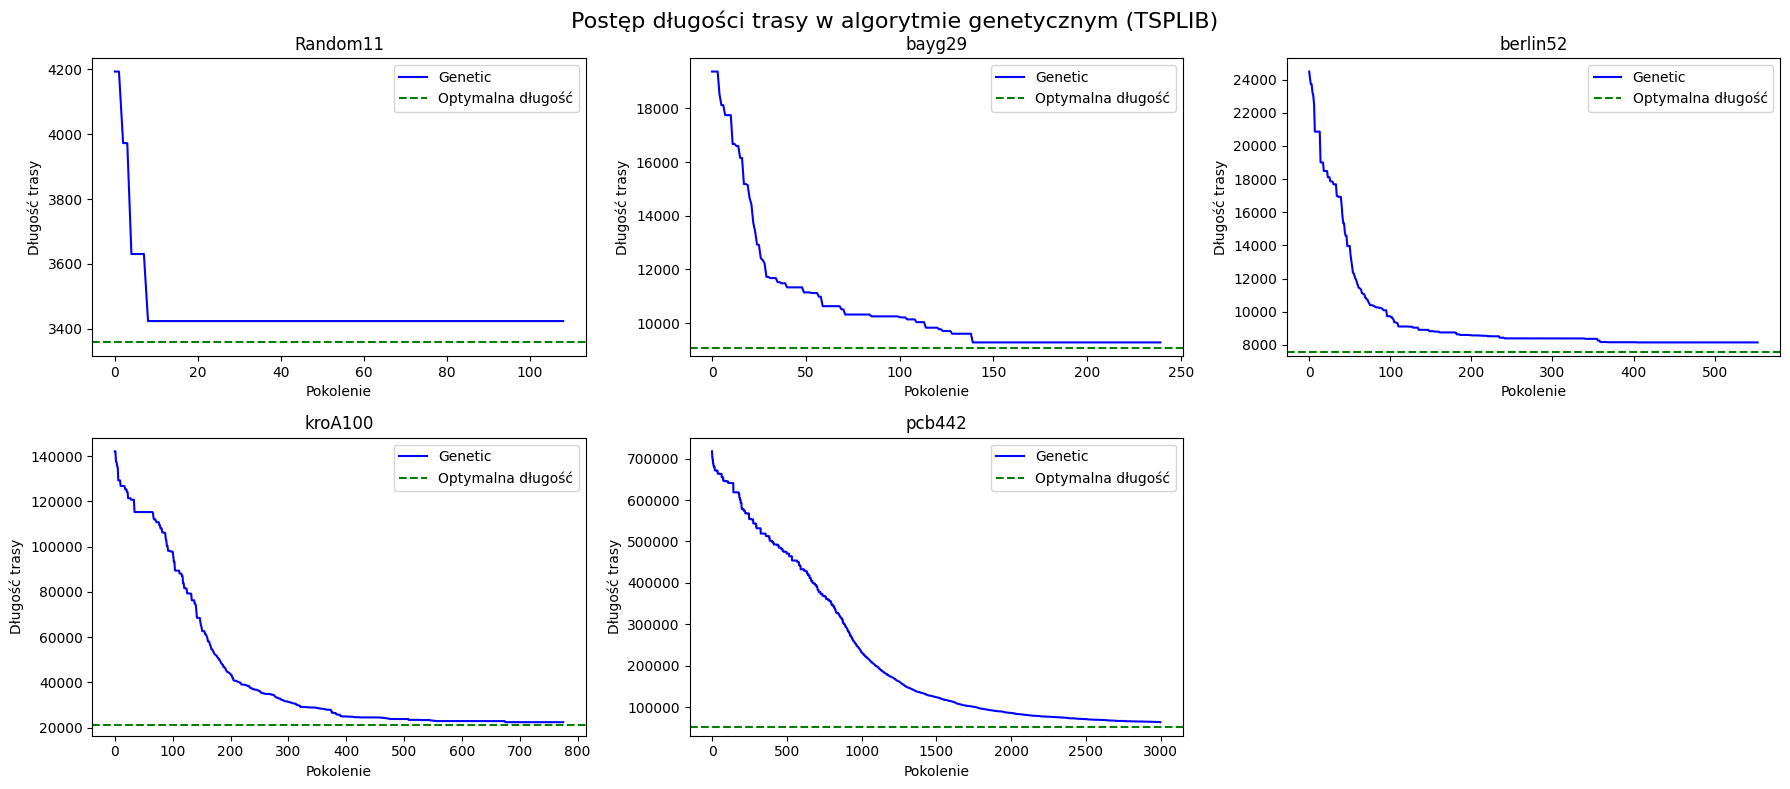

In [127]:
df_fitness = df_tsplib[
    (df_tsplib["algorithm"] == "Genetic") & 
    (df_tsplib["fitness_history"].notna())
].copy()
df_fitness["fitness_history"] = df_fitness["fitness_history"].apply(lambda x: ast.literal_eval(str(x)))

optimal_df = df_tsplib[df_tsplib["algorithm"] == "Optimal"][["instance", "distance"]]
optimal_df = optimal_df.rename(columns={"distance": "optimal_distance"})

df_fitness = df_fitness.merge(optimal_df, on="instance", how="left")

num_instances = len(df_fitness)
cols = 3
rows = (num_instances + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, (_, row) in zip(axes, df_fitness.iterrows()):
    distance_history = [1 / f for f in row["fitness_history"]]
    ax.plot(distance_history, label="Genetic", color="blue")
    
    if not pd.isna(row["optimal_distance"]):
        ax.axhline(row["optimal_distance"], color="green", linestyle="--", label="Optymalna długość")

    ax.set_title(f"{row['instance']}")
    ax.set_xlabel("Pokolenie")
    ax.set_ylabel("Długość trasy")
    ax.legend()

for i in range(len(df_fitness), len(axes)):
    axes[i].axis("off")

plt.suptitle("Postęp długości trasy w algorytmie genetycznym (TSPLIB)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## 4. Wnioski
Zaimplementowany algorytm genetyczny okazał się skuteczną metodą rozwiązywania problemu komiwojażera. W ogólnych przypadkach regularnie przewyższał jakością rozwiązania zarówno prosty algorytm zachłanny Nearest Neighbour, jak i lokalne ulepszanie za pomocą 2-opt. Najlepsze rezultaty osiągnięto, łącząc GA z lokalnym ulepszaniem 2-opt – taka hybryda często dawała wyniki bliskie znanego optimum. Warto jednak zaznaczyć, że w niektórych przypadkach (np. instancja pcb442) prostsze algorytmy potrafiły znaleźć lepsze rozwiązanie niż GA.

Główną wadą GA jest czas działania – złożoność obliczeniowa algorytmu rośnie znacznie szybciej niż w przypadku NN czy 2-opt. Dla instancji ze 100 miastami, GA potrzebował średnio ok. 35 sekund, podczas gdy NN średnio kończył w 0.02s, a 2-opt (z losowej permutacji) – średnio w ok. 1.7s. To pokazuje, że cena za lepsze rozwiązanie jest znaczna. 


Zastosowany grid search pozwolił znaleźć kombinację parametrów, która zapewniała jak najlepszą jakość znalezionych tras. Najlepiej sprawdziły się:
- selekcja turniejowa,
- mutacja typu inversion,
- mutation rate 10%,
- krzyżowanie typu pmx-crossover


Model wykazywał dobrą zbieżność, a zastosowany mechanizm wczesnego stopu (brak poprawy przez 100 pokoleń) pozwalał skrócić czas działania, gdy rozwiązanie było już wystarczająco dobre. Należy jednak zauważyć, że dla większych instancji (powyżej 100 miast) limit 3000 pokoleń może być niewystarczający.

Podsumowując, stworzony model dobrze sprawdza się jako metoda metaheurystyczna, szczególnie w połączeniu z lokalnym ulepszaniem. Przy większych instancjach należy jednak uważać na czas wykonania.